## Survival Analysis: univariate and regression models

Materials:
- A Guide to Model Selection For Survival Analysis [Link](https://towardsdatascience.com/a-guide-to-model-selection-for-survival-analysis-2500b211c733)
- Survival Analysis — Part A [Link](https://towardsdatascience.com/survival-analysis-part-a-70213df21c2e)
- The Cox Proportional Hazards Model [Link](https://towardsdatascience.com/the-cox-proportional-hazards-model-35e60e554d8f)
- The Stratified Cox Proportional Hazards Regression Model [Link](https://towardsdatascience.com/the-stratified-cox-proportional-hazards-regression-model-fa1fa5de2bb1)

Dataset load

In [80]:
import pandas as pd
from lifelines.datasets import load_rossi

# load data set
df = load_rossi()
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


## Univariate models

### 1 - Kaplan Meier Model
The Kaplan-Meier model is arguably the most well-known model in survival analysis.

It is classified as a non-parametric model, meaning that it does not assume the distribution of the data. It generates a survival function with only the information provided.

The Kaplan Meier model computes the survival function with the formula:

$S(t) = \prod\limits_{i:t_t \leq t}(1-\dfrac{d_i}{n_i})$

In [69]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# fit data into Kaplan Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=df['week'], 
        event_observed=df['arrest'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 432 total observations, 318 right-censored observations>

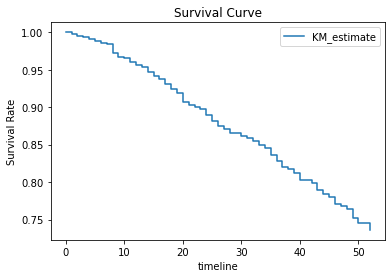

In [70]:
# plot survival curve
kmf.plot(ci_show=False)
plt.ylabel('Survival Rate')
plt.title('Survival Curve')
plt.show()

The survival functions of different groups can be compared with the log-rank test, a non-parametric hypothesis test.

As an example, we can compare the survival functions of subjects with and without financial aid to see if financial aid affects the survival duration using the logrank_test method

In [71]:
from lifelines.statistics import logrank_test

# separating subjects with and without financial aid
df_fin = df[df['fin']==1]
df_no_fin = df[df['fin']==0]


In [72]:
# perform log rank test to compare subjects with and without aid
results = logrank_test(durations_A=df_fin['week'],
                      event_observed_A=df_fin['arrest'],
                      durations_B=df_no_fin['week'],
                      event_observed_B=df_no_fin['arrest'])
results = results.summary
print(f'P-value: {results.p[0]}')

P-value: 0.050116117409005845


p-value < 0.05 (below the 5% level)is statistical significant which denotes that we have to regret null hypothesis and to extract the information that survival functions are significantly different.

The benefit of the Kaplan Meier model is that it is intuitive and easy to interpret. As it makes few underlying assumptions, **this model is often used as a baseline in survival analysis.**

In [73]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

print(df.head())
T = df['T']
E = df['E']

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


In [74]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 163 total observations, 7 right-censored observations>

In [75]:
kmf.survival_function_.head()

,KM_estimate
timeline,
0.0,1.000000
6.0,0.993865
7.0,0.987730
9.0,0.969210
13.0,0.950690


In [76]:
kmf.cumulative_density_.head()

,KM_estimate
timeline,
0.0,0.000000
6.0,0.006135
7.0,0.012270
9.0,0.030790
13.0,0.049310


<AxesSubplot:xlabel='timeline'>

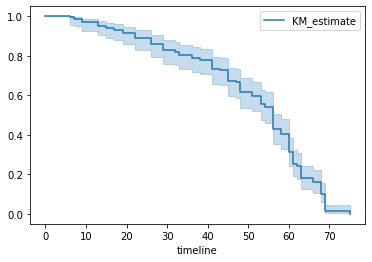

In [77]:
kmf.plot_survival_function()

### 2 - Exponential Model
The Exponential model is another popular model in survival analysis. Unlike the Kaplan Meier model, it is a parametric model, meaning that it assumes that the data fits a specific distribution.

The survival function of the Exponential model is derived from the formula:

$S(t) = exp(-\dfrac{t}{\lambda})$

The hazard rate of the Exponential model is derived from the formula:

$h(t) = \dfrac{1}{\lambda}$

The exponential model assumes that the hazard rate is constant. In other words, the risk of the event of interest occurring remains the same throughout the period of observation.

In [81]:
from lifelines import ExponentialFitter

# fit data into Exponential estimator
ef = ExponentialFitter()
ef.fit(durations=df['week'], 
        event_observed=df['arrest'])

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 432 total observations, 318 right-censored observations>

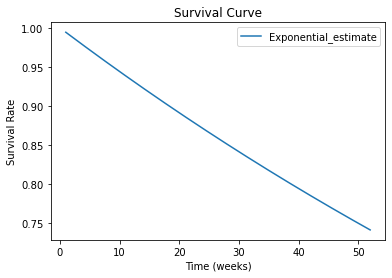

In [82]:
# plot survival curve
ef.survival_function_.plot()
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Rate')
plt.title('Survival Curve')
plt.show()

In [83]:
# compute lambda
lambda_value = ef.lambda_
print(f'λ = {lambda_value}')

λ = 173.76318376751396


In [84]:
hazard_df = pd.concat([ef.hazard_, ef.cumulative_hazard_], axis=1)
hazard_df.columns = ['Hazard Rate', 'Cummulative Hazard']
hazard_df.head()

,Hazard Rate,Cummulative Hazard
1.000000,0.005755,0.005755
1.118329,0.005755,0.006436
1.236659,0.005755,0.007117
1.354988,0.005755,0.007798
1.473318,0.005755,0.008479


Overall, the Exponential model provides substantial information on the survival function and the hazard function. Moreover, it can be used to compare the hazard rates of different groups.

However, it makes the strong assumption that the hazard rate is constant at any given time, which may not suit the time-to-event data of interest.

### 3 - Weibull Model
Another parametric model one can consider is the Weibull model.

The survival rate in a Weibull model is determined by the following formula:

$S(t) = exp(-(\dfrac{t}{\lambda})^\rho)$

The hazard rate in a Weibull model is determined by the following formula:

$h(t) = \dfrac{\rho}{\lambda}(\dfrac{t}{\lambda})^{\rho-1}$

The data distribution in the Weibull model is determined by the two parameters: λ and ρ.

The λ parameter indicates how long it takes for 63.2% of the subjects to experience the event.

The ρ parameter indicates whether the hazard rate is increasing, decreasing, or constant. If ρ is greater than 1, the hazard rate is constantly increasing. If ρ is less than 1, the hazard rate is constantly decreasing.

In other words, the Weibull model assumes that the change in hazard rate is linear. The hazard rate can always increase, always decrease, or stay the same. However, the hazard rate can not fluctuate.

In [85]:
from lifelines import WeibullFitter

# fit data into Weibull estimator
wf = WeibullFitter()
wf.fit(durations=df['week'], 
        event_observed=df['arrest'])



<lifelines.WeibullFitter:"Weibull_estimate", fitted with 432 total observations, 318 right-censored observations>

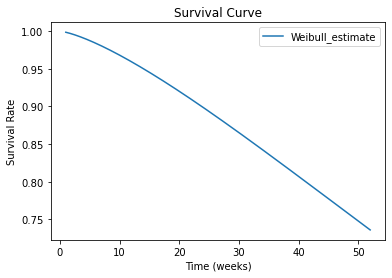

In [86]:
wf.survival_function_.plot()
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Rate')
plt.title('Survival Curve')
plt.show()

In [87]:
# compute lambda and rho
lambda_value = wf.lambda_
rho_value = wf.rho_
print(f'λ= {lambda_value}')
print(f'ρ= {rho_value}')

λ= 123.67708708943374
ρ= 1.3651415090782515


Since the ρ value is greater than 1, the hazard rate in this model is always increasing.

We can confirm this by deriving the hazard rate and cumulative hazard function.

In [88]:
# Compute hazard function and cumulative hazard function
hazard_df = pd.concat([wf.hazard_, wf.cumulative_hazard_], axis=1)
hazard_df.columns = ['Hazard Rate', 'Cummulative Hazard']
hazard_df.head()

,Hazard Rate,Cummulative Hazard
1.000000,0.001901,0.001392
1.118329,0.001980,0.001622
1.236659,0.002054,0.001861
1.354988,0.002124,0.002108
1.473318,0.002190,0.002363


Similar to the Exponential model, the Weibull model is capable of computing many of the relevant metrics in the survival analysis.

However, its results are based on the strong assumption that the hazard rate changes linearly across time, which may not suit the time-to-event data in question.

## Regression models

> If you **know the parametric distribution** that your data follows then using a maximum likelihood approach and the distribution makes sense

> The real advantage of Cox Proportional Hazards regression is that you can still fit survival models **without knowing (or assuming) the distribution**


>With censoring and covariates we cannot do a simple histogram and say "that looks like a ... distribution to me". So it is very useful to have a technique that **works well without needing a specific distribution**

### 4 - Cox Proportional-Hazards Model
Although the Exponential model and the Weibull model can evaluate covariates, they can only examine each covariate individually.

If the goal is to conduct a survival analysis that examines time-to-event data with respect to multiple variables at once, the Cox Proportional-Hazards model (also known as the Cox model) can be the preferable alternative.

It is based on the following hazard rate formula:

$h(t|x) = b_0(t) exp( \sum\limits_{i=1}^{n}(x_i-\bar{x_i}) )$

The Cox model allows the hazard rate to fluctuate, as opposed to the parametric models where the hazard rate adheres to a fixed pattern.

The model is, however, dependent on **the proportional hazards assumption** <br/>
It assumes that the hazard ratios between groups remain constant. In other words, no matter how the hazard rates of the subjects change during the period of observation, the hazard rate of one group relative to the other will always stay the same.

**Estimation** <br/>
The estimation of the model is obtained by Maximun Likelihood, particularly maximazing the "partial" likelihood function rather than a (complete) likelihood function. The term "partial" likelihood is used because the likelihood formula considers probabilities only for those subjects who fail, and does not explicitly consider probabilities for those subjects who are censored

In [89]:
from lifelines import CoxPHFitter

# fit the Cox Proportional-Hazards model
cf = CoxPHFitter()
cf.fit(df, 'week', 'arrest')


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

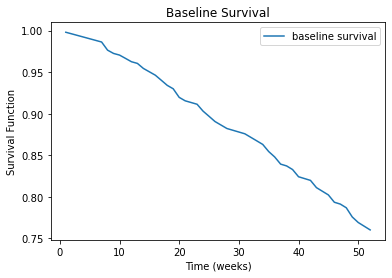

In [90]:
# baseline survival plot
cf.baseline_survival_.plot()
plt.title('Baseline Survival')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Function')
plt.show()

In [91]:
# show the summary
cf.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
fin,-0.379422,0.684257,0.191379,-0.754519,-0.004325,0.470237,0.995684,0.0,-1.982565,0.047416,4.398479
age,-0.057438,0.944181,0.021999,-0.100556,-0.014320,0.904335,0.985782,0.0,-2.610869,0.009031,6.790860
race,0.313900,1.368753,0.307993,-0.289755,0.917555,0.748447,2.503162,0.0,1.019179,0.308118,1.698445
wexp,-0.149796,0.860884,0.212224,-0.565748,0.266156,0.567935,1.304939,0.0,-0.705837,0.480290,1.058023
mar,-0.433704,0.648104,0.381868,-1.182152,0.314744,0.306618,1.369908,0.0,-1.135743,0.256064,1.965422
paro,-0.084871,0.918631,0.195757,-0.468547,0.298805,0.625911,1.348247,0.0,-0.433554,0.664612,0.589415
prio,0.091497,1.095814,0.028649,0.035347,0.147647,1.035979,1.159104,0.0,3.193777,0.001404,9.475989


This means that being getting financial aid changes the hazard rate by a factor of 0.68 (i.e., a 32% decrease).

Of course, the Cox model is only suitable if its assumption of proportional hazards befits the time-to-event data. To justify the use of the model, one can test this assumption using the check_assumptions method.

In [92]:
# check assumptions
cf.check_assumptions(training_df=df)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

[]

### Example with Rossi data

In [93]:
from lifelines.datasets import load_rossi

In [94]:
rossi = load_rossi()

In [95]:
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [96]:
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.50881, step_size = 0.9500, log_lik = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13852, step_size = 0.9500, log_lik = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01802, step_size = 0.9500, log_lik = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00018, step_size = 1.0000, log_lik = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.


/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2022-09-06 15:48:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.98   0.05       4.40
age           0.00 -2.61   0.01       6.79
race          0.00  1.02   0.31       1.70
wexp          0.00 -0.71   0.48       1.06
mar           0.00 -1.14   0.26       1.97
paro          0.00 -0.43   0.66       0.59
prio          0.00  3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

<AxesSubplot:xlabel='log(HR) (95% CI)'>

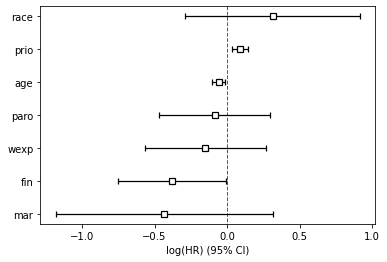

In [97]:
cph.plot()

In [98]:
rossi['age'].describe()

count    432.000000
mean      24.597222
std        6.113375
min       17.000000
25%       20.000000
50%       23.000000
75%       27.000000
max       44.000000
Name: age, dtype: float64

<AxesSubplot:>

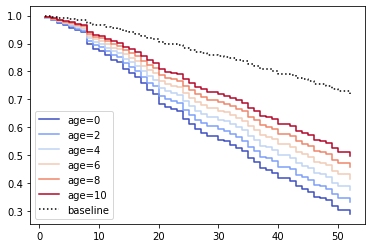

In [99]:
cph.plot_partial_effects_on_outcome(covariates='age', 
                                    values=[0, 2, 4, 6, 8, 10], 
                                    cmap='coolwarm')

In [100]:
cph.params_

covariate
fin    -0.379422
age    -0.057438
race    0.313900
wexp   -0.149796
mar    -0.433704
paro   -0.084871
prio    0.091497
Name: coef, dtype: float64

`prio` (the number of prior arrests) - a one unit increase in prio means the the baseline hazard will increase by a factor of exp(0.09)=1.10 - about a 10% increase 

`mar` (whether the subject is married or not) - the value of coefficient exp(-.43) is the value of ratio of hazards associated with being married: <br/>

$ exp(-.43) = \dfrac{hazard \ of \ married \ subjects \ at \ time \ t}{hazard \ of \ unmarried \ subjects \ at \ time \ t} $

**The proportional hazard assumption** is that relationship between two factors that may vary with time is constant. two factors that may vary with time. That is, hazards can change over time, but their ratio between levels remains a constant.

In [101]:
cph.baseline_hazard_.head(5)

,baseline hazard
1.0,0.001958
2.0,0.001964
3.0,0.001965
4.0,0.001969
5.0,0.001975


In [102]:
cph.predict_survival_function(rossi).head()

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
1.0,0.997616,0.993695,0.994083,0.999045,0.997626,0.997578,0.998865,0.997827,0.995453,0.997462,...,0.997826,0.996005,0.996031,0.997774,0.998892,0.999184,0.997033,0.998866,0.998170,0.998610
2.0,0.995230,0.987411,0.988183,0.998089,0.995250,0.995154,0.997728,0.995653,0.990914,0.994922,...,0.995649,0.992014,0.992067,0.995547,0.997782,0.998366,0.994065,0.997730,0.996337,0.997217
3.0,0.992848,0.981162,0.982314,0.997133,0.992878,0.992734,0.996592,0.993482,0.986392,0.992388,...,0.993476,0.988037,0.988115,0.993324,0.996673,0.997548,0.991105,0.996595,0.994507,0.995826
4.0,0.990468,0.974941,0.976468,0.996176,0.990507,0.990316,0.995455,0.991311,0.981882,0.989855,...,0.991304,0.984067,0.984171,0.991100,0.995563,0.996729,0.988147,0.995458,0.992676,0.994433
5.0,0.988085,0.968739,0.970639,0.995216,0.988135,0.987895,0.994315,0.989139,0.977378,0.987320,...,0.989129,0.980101,0.980231,0.988875,0.994450,0.995909,0.985189,0.994319,0.990843,0.993039


In [103]:
cph.predict_partial_hazard(rossi).head()

0    1.219126
1    3.230250
2    3.031058
3    0.487712
4    1.214025
dtype: float64

### Goodness of fit

1. inspect the survival probability calibration plot 

In [104]:
from lifelines.calibration import survival_probability_calibration

ICI =  0.010252513188766254
E50 =  0.00963384110482235


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 25 mortality'}, xlabel='Predicted probability of \nt ≤ 25 mortality', ylabel='Observed probability of \nt ≤ 25 mortality'>,
 0.010252513188766254,
 0.00963384110482235)

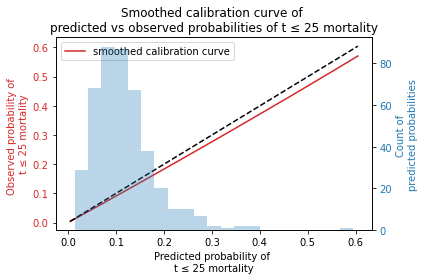

In [105]:
survival_probability_calibration(cph, rossi, t0=25)

2. look at the concordance-index  <br/>
Evaluates the accuracy of the ranking of predicted time

It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:

- 0.5 is the expected result from random predictions,
- 1.0 is perfect concordance and,
- 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

For the Cox model, it depends on the estimated hazard-ratio. If the ratio, 𝑒𝛽 is >1 then larger values of 𝑋 imply larger risks thus shorter times. So if $𝑒^𝛽$>1 a couple is concordant if 𝑋1>𝑋2 and 𝑇1<𝑇2, and if $𝑒^𝛽$<1 a couple is concordant if 𝑋1<𝑋2 and 𝑇1<𝑇2.

In [106]:
cph.concordance_index_

0.6403292470997135

3. look at the log-likelihood test <br/>
Compare the existing model (with all the covariates) to the trivial model of no covariates

In [22]:
cph.log_likelihood_ratio_test()

/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 7
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          33.27 <0.005     15.37

4. check the proportional hazards assumption

### Checking the proportional hazards assumption

In [24]:
cph.check_assumptions(rossi)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

[]

**Stratification** <br/>
Sometimes one or more covariates may not obey the proportional hazard assumption. In this case, we can allow the covariate(s) to still be including in the model without estimating its effect.

In [49]:
#To specify variables to be used in stratification, we define them in the call to fit()
cph.fit(rossi, 'week', event_col='arrest', strata=['wexp'])
cph.print_summary()

/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = ['wexp']
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -580.89
         time fit was run = 2022-09-06 12:16:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.76            -0.01                 0.47                 0.99
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.36       0.31            -0.30             0.91                 0.74                 2.49
mar        -0.45       0.64       0.38            -1.20             0.29                 0.30                 1.34
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.09       0.03             0.03             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.99   0.05       4.42
age           0.00 -2.64   0.01       6.91
race          0.00  1.00   0.32       1.65
mar           0.00 -1.19   0.23       2.09
paro          0.00 -0.42   0.67       0.57
prio          0.00  3.16 <0.005       9.33
---
Concordance = 0.61
Partial AIC = 1173.77
log-likelihood ratio test = 23.77 on 6 df
-log2(p) of ll-ratio test = 10.77

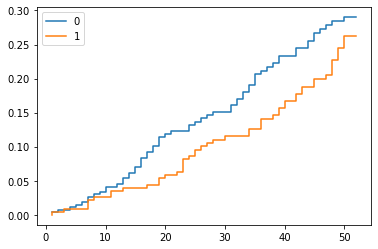

In [51]:
cph.baseline_survival_.shape
# (49, 2)
cph.baseline_cumulative_hazard_.plot(drawstyle="steps");

**Weights & robust errors** <br/>
When using sampling weights, it’s correct to also change the standard error calculations. That is done by turning on the robust flag.

In [107]:
df = pd.DataFrame({
    'T': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'E': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'weights': [1.1, 0.5, 2.0, 1.6, 1.2, 4.3, 1.4, 4.5, 3.0, 3.2, 0.4, 6.2],
    'month': [10, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'age': [4, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
})

cph = CoxPHFitter()
cph.fit(df, 'T', 'E', weights_col='weights', robust=True)
cph.print_summary()

/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 29.4 total observations, 12.1 right-censored observations>
             duration col = 'T'
                event col = 'E'
              weights col = 'weights'
          robust variance = True
      baseline estimation = breslow
   number of observations = 29.4
number of events observed = 17.3
   partial log-likelihood = -20.54
         time fit was run = 2022-09-06 15:55:11 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
month      -3.15       0.04       0.14            -3.42            -2.89                 0.03                 0.06
age       -15.77       0.00       0.49           -16.73           -14.81                 0.00                 0.00

            cmp to      z      p   -log2(p)
covariate                                  
month         0.00 -22.98 <0.005     385.78
age           0.00 -32.12 <0.005     749.50
---
Concordance = 0.97
Partial AIC = 45.08
log-likelihood ratio test = 46.45 on 2 df
-log2(p) of ll-ratio test = 33.50